## **Load Dataset**

In [0]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('Masked_User_Rest_Ratings.csv')
# dataset = pd.read_csv('train_dataset.csv')
test_dataset = pd.read_csv('TestUsers.csv')
dataset['User']=dataset['User'].astype('int')
dataset['Restaurant']=dataset['Restaurant'].astype('int')
dataset['Ratings']=dataset['Ratings'].astype('int')
dataset.head()

,User,Restaurant,Ratings
0,313986,170,5
1,261673,595,2
2,33533,358,1
3,251355,3502,1
4,324430,1251,5


## **Prepare Test Data**

For test data, we considered top 50 users who have rated the maximum restaurants.

In [0]:
test_dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [0]:
uniq_res_ids = dataset['Restaurant'].unique()

In [0]:
test_list = []
for i in test_dataset['Users']:
  for j in uniq_res_ids:
    test_list.append([i, j])
len(test_list)

3180250

In [0]:
test_data = pd.DataFrame(test_list, columns=['User', 'Restaurant'])

## **Adding Validation Set into Test Set**

In [0]:
add_on_data = pd.DataFrame(columns=['User', 'Restaurant', 'Ratings'])
for i in test_dataset['Users']:
  add_on_data = add_on_data.append(dataset[dataset['User']==i].sort_values(ascending=False, by="Ratings")[:10], ignore_index=True)

In [0]:
X_test_add_on= add_on_data.loc[:,['User', 'Restaurant']]
Y_test_add_on = add_on_data.loc[:,['Ratings']]

In [0]:
test_data = test_data.append(X_test_add_on, ignore_index=True)

## **Dense Neural Network**

Create FastAI CollabDataBunch Object

In [0]:
from fastai.collab import *
data = CollabDataBunch.from_df(dataset, seed=42, valid_pct=0.1, user_name='User', item_name='Restaurant', rating_name='Ratings', test=test_data)

In [0]:
data.show_batch()

User,Restaurant,target
392426,53912,4.0
408147,50679,4.0
1351377,55520,5.0
166946,10175,1.0
158798,49896,5.0


Model architecture is defined below which contains two dense layers having 256 and 128 neurons resp. and Embedding of 50 neurons each is added form User and Restaurant. Dropout Layers are added to avoid overfitting.

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'User': 100, 'Restaurant':100},emb_drop=0.25,ps=[0.5,0.5], layers=[256, 128], y_range=(1, 5))


To find the appropriate learning rate for our architecture, we used lr_find function provided by FastAI.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


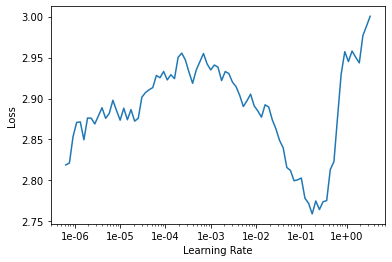

In [0]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [0]:
from fastai.callbacks.tracker import  *
learn.fit_one_cycle(1, 1e-2, callbacks=[SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='collab_model'), EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,time


Buffered data was truncated after reaching the output size limit.

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
preds= learn.get_preds(ds_type=DatasetType.Test)
preds = preds[0].numpy()

## **Restaurant Recommendations**

In [0]:
prediction_df = pd.DataFrame(columns=['User', 'Restaurant', 'Predicted Ratings'])
prediction_df['User']=test_data['User'].values
prediction_df['Restaurant']=test_data['Restaurant'].values
prediction_df['Predicted Ratings']=preds
prediction_df.head()



,User,Restaurant,Predicted Ratings
0,4401,170,3.335582
1,4401,595,3.685613
2,4401,358,3.022434
3,4401,3502,3.169023
4,4401,1251,3.659316


In [0]:
top_10_test_pred = pd.DataFrame(columns=['User', 'Restaurant', 'Predicted Ratings'])
for i in prediction_df['User'].unique():
  top_10_test_pred = top_10_test_pred.append(prediction_df[prediction_df['User']==i].sort_values(ascending=False, by='Predicted Ratings')[:10], ignore_index=True)

In [0]:
top_10_test_pred.to_csv('TestDataRecommendation.csv', index=False, index_label=False)

=======================

In [0]:
import pandas as pd
recommendations = pd.read_csv('Results-Amit/TestDataRecommendation.csv')
recommendations.head(10)

,User,Restaurant,Predicted Ratings
0,4401,43076,4.604823
1,4401,33485,4.558684
2,4401,48809,4.541618
3,4401,49702,4.507235
4,4401,54783,4.488658
5,4401,32418,4.484332
6,4401,50791,4.476749
7,4401,14139,4.462414
8,4401,16971,4.460520
9,4401,49979,4.459648


In [0]:
result = pd.DataFrame(columns=['Actual Ratings', 'Predicted Ratings'])
result['Actual Ratings']= Y_test
result['Predicted Ratings']= preds
result.reset_index(inplace=True, drop=True)
result.head()

,Actual Ratings,Predicted Ratings
0,2,3.508652
1,5,3.127908
2,5,4.440498
3,5,3.072863
4,5,3.773086


In [0]:
pd.DataFrame(preds).to_csv('Predictions_epoch_1.csv', index=None, index_label=None)

In [0]:
prediction = pd.DataFrame(columns=['Id','Rating'])
prediction['Id']=xx
prediction['Rating']=preds.reshape(-1)
prediction.to_csv('outputs.csv', index_label=False,index=False)